<a href="https://colab.research.google.com/github/Syilun/TibameAI04/blob/master/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [3]:


class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
#         fig.savefig("images/%d.png" % epoch)
        plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

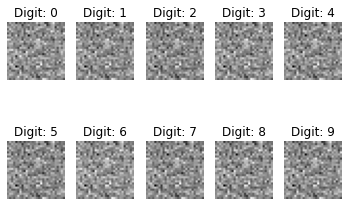

1 [D loss: 0.695678, acc.: 21.88%] [G loss: 0.684619]
2 [D loss: 0.684369, acc.: 48.44%] [G loss: 0.678566]
3 [D loss: 0.678529, acc.: 50.00%] [G loss: 0.668830]
4 [D loss: 0.672091, acc.: 50.00%] [G loss: 0.663449]
5 [D loss: 0.662848, acc.: 50.00%] [G loss: 0.653160]
6 [D loss: 0.653393, acc.: 50.00%] [G loss: 0.648781]
7 [D loss: 0.634702, acc.: 50.00%] [G loss: 0.633543]
8 [D loss: 0.613918, acc.: 50.00%] [G loss: 0.622122]
9 [D loss: 0.601940, acc.: 50.00%] [G loss: 0.605430]
10 [D loss: 0.573236, acc.: 50.00%] [G loss: 0.603793]
11 [D loss: 0.537400, acc.: 59.38%] [G loss: 0.584744]
12 [D loss: 0.500922, acc.: 75.00%] [G loss: 0.564523]
13 [D loss: 0.464940, acc.: 87.50%] [G loss: 0.578147]
14 [D loss: 0.417511, acc.: 96.88%] [G loss: 0.548168]
15 [D loss: 0.379478, acc.: 98.44%] [G loss: 0.553076]
16 [D loss: 0.342916, acc.: 100.00%] [G loss: 0.517898]
17 [D loss: 0.302056, acc.: 100.00%] [G loss: 0.497271]
18 [D loss: 0.286849, acc.: 98.44%] [G loss: 0.596151]
19 [D loss: 0.230

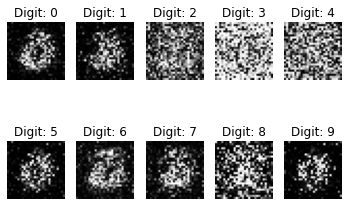

201 [D loss: 0.216511, acc.: 93.75%] [G loss: 3.806585]
202 [D loss: 0.499195, acc.: 79.69%] [G loss: 4.421709]
203 [D loss: 0.287636, acc.: 85.94%] [G loss: 4.476837]
204 [D loss: 0.200026, acc.: 93.75%] [G loss: 4.098005]
205 [D loss: 0.225061, acc.: 90.62%] [G loss: 4.146792]
206 [D loss: 0.404699, acc.: 84.38%] [G loss: 3.119203]
207 [D loss: 0.268164, acc.: 92.19%] [G loss: 4.132051]
208 [D loss: 0.242915, acc.: 90.62%] [G loss: 4.599966]
209 [D loss: 0.332247, acc.: 90.62%] [G loss: 3.926078]
210 [D loss: 0.431353, acc.: 85.94%] [G loss: 4.130881]
211 [D loss: 0.326718, acc.: 87.50%] [G loss: 3.883122]
212 [D loss: 0.157007, acc.: 95.31%] [G loss: 3.599122]
213 [D loss: 0.225205, acc.: 92.19%] [G loss: 4.204193]
214 [D loss: 0.329261, acc.: 85.94%] [G loss: 4.490172]
215 [D loss: 0.348513, acc.: 87.50%] [G loss: 3.973562]
216 [D loss: 0.426820, acc.: 81.25%] [G loss: 3.145647]
217 [D loss: 0.412392, acc.: 82.81%] [G loss: 3.508517]
218 [D loss: 0.367668, acc.: 81.25%] [G loss: 3.

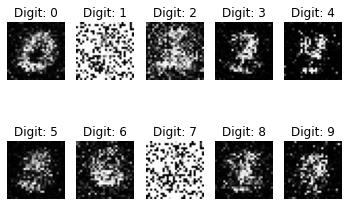

401 [D loss: 0.362195, acc.: 87.50%] [G loss: 2.147634]
402 [D loss: 0.312381, acc.: 92.19%] [G loss: 2.295638]
403 [D loss: 0.435694, acc.: 81.25%] [G loss: 2.288490]
404 [D loss: 0.429669, acc.: 81.25%] [G loss: 2.096775]
405 [D loss: 0.435011, acc.: 76.56%] [G loss: 2.383373]
406 [D loss: 0.425129, acc.: 82.81%] [G loss: 2.434176]
407 [D loss: 0.834827, acc.: 48.44%] [G loss: 2.044854]
408 [D loss: 0.311548, acc.: 90.62%] [G loss: 2.444654]
409 [D loss: 0.498764, acc.: 75.00%] [G loss: 2.006032]
410 [D loss: 0.462950, acc.: 76.56%] [G loss: 1.814310]
411 [D loss: 0.481525, acc.: 73.44%] [G loss: 2.009509]
412 [D loss: 0.641810, acc.: 67.19%] [G loss: 1.690158]
413 [D loss: 0.476015, acc.: 78.12%] [G loss: 2.136334]
414 [D loss: 0.432460, acc.: 81.25%] [G loss: 1.921134]
415 [D loss: 0.322169, acc.: 87.50%] [G loss: 1.872901]
416 [D loss: 0.619055, acc.: 73.44%] [G loss: 1.699508]
417 [D loss: 0.534597, acc.: 68.75%] [G loss: 2.215411]
418 [D loss: 0.506722, acc.: 78.12%] [G loss: 1.

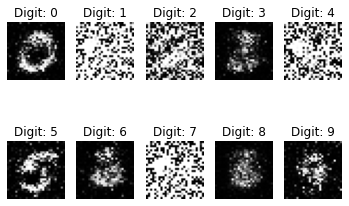

601 [D loss: 0.528960, acc.: 70.31%] [G loss: 1.883454]
602 [D loss: 0.461568, acc.: 76.56%] [G loss: 2.168371]
603 [D loss: 0.372006, acc.: 85.94%] [G loss: 2.055866]
604 [D loss: 0.463094, acc.: 84.38%] [G loss: 1.976233]
605 [D loss: 0.472181, acc.: 78.12%] [G loss: 1.876751]
606 [D loss: 0.518131, acc.: 76.56%] [G loss: 2.079149]
607 [D loss: 0.412283, acc.: 81.25%] [G loss: 2.393051]
608 [D loss: 0.438795, acc.: 78.12%] [G loss: 1.943661]
609 [D loss: 0.563410, acc.: 71.88%] [G loss: 2.135640]
610 [D loss: 0.548751, acc.: 71.88%] [G loss: 2.266760]
611 [D loss: 0.415592, acc.: 81.25%] [G loss: 1.782081]
612 [D loss: 0.472657, acc.: 70.31%] [G loss: 2.060026]
613 [D loss: 0.497639, acc.: 68.75%] [G loss: 2.053771]
614 [D loss: 0.511998, acc.: 73.44%] [G loss: 2.292312]
615 [D loss: 0.523189, acc.: 71.88%] [G loss: 2.138728]
616 [D loss: 0.485179, acc.: 79.69%] [G loss: 2.277071]
617 [D loss: 0.424746, acc.: 81.25%] [G loss: 1.943541]
618 [D loss: 0.547615, acc.: 73.44%] [G loss: 1.

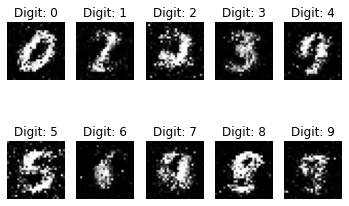

801 [D loss: 0.485172, acc.: 71.88%] [G loss: 1.636987]
802 [D loss: 0.751428, acc.: 54.69%] [G loss: 1.671166]
803 [D loss: 0.543217, acc.: 68.75%] [G loss: 1.952876]
804 [D loss: 0.518520, acc.: 71.88%] [G loss: 1.680904]
805 [D loss: 0.523424, acc.: 75.00%] [G loss: 1.627527]
806 [D loss: 0.485405, acc.: 73.44%] [G loss: 1.687747]
807 [D loss: 0.581573, acc.: 75.00%] [G loss: 1.639471]
808 [D loss: 0.630514, acc.: 60.94%] [G loss: 1.809530]
809 [D loss: 0.527701, acc.: 73.44%] [G loss: 1.862470]
810 [D loss: 0.730565, acc.: 53.12%] [G loss: 1.640668]
811 [D loss: 0.630721, acc.: 65.62%] [G loss: 1.537213]
812 [D loss: 0.586992, acc.: 65.62%] [G loss: 1.462603]
813 [D loss: 0.509695, acc.: 73.44%] [G loss: 1.458615]
814 [D loss: 0.538699, acc.: 76.56%] [G loss: 1.123125]
815 [D loss: 0.535501, acc.: 78.12%] [G loss: 1.702961]
816 [D loss: 0.652465, acc.: 65.62%] [G loss: 1.519082]
817 [D loss: 0.534784, acc.: 71.88%] [G loss: 1.872694]
818 [D loss: 0.598828, acc.: 64.06%] [G loss: 1.

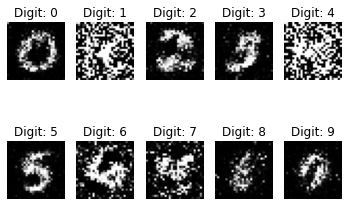

1001 [D loss: 0.653226, acc.: 59.38%] [G loss: 1.452885]
1002 [D loss: 0.528718, acc.: 75.00%] [G loss: 1.535829]
1003 [D loss: 0.552464, acc.: 71.88%] [G loss: 1.430623]
1004 [D loss: 0.519611, acc.: 76.56%] [G loss: 1.461834]
1005 [D loss: 0.492404, acc.: 70.31%] [G loss: 1.681051]
1006 [D loss: 0.686120, acc.: 57.81%] [G loss: 1.698874]
1007 [D loss: 0.603630, acc.: 67.19%] [G loss: 1.468276]
1008 [D loss: 0.684307, acc.: 62.50%] [G loss: 1.314005]
1009 [D loss: 0.446519, acc.: 84.38%] [G loss: 1.321175]
1010 [D loss: 0.669685, acc.: 64.06%] [G loss: 1.459913]
1011 [D loss: 0.548712, acc.: 75.00%] [G loss: 1.615091]
1012 [D loss: 0.523948, acc.: 75.00%] [G loss: 1.342072]
1013 [D loss: 0.574916, acc.: 68.75%] [G loss: 1.446683]
1014 [D loss: 0.646552, acc.: 56.25%] [G loss: 1.410024]
1015 [D loss: 0.547119, acc.: 68.75%] [G loss: 1.210772]
1016 [D loss: 0.576162, acc.: 75.00%] [G loss: 1.371951]
1017 [D loss: 0.693864, acc.: 57.81%] [G loss: 1.461061]
1018 [D loss: 0.559186, acc.: 7

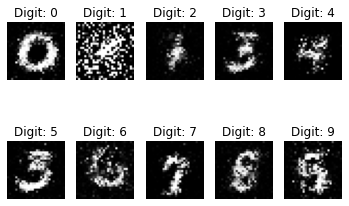

1201 [D loss: 0.515242, acc.: 75.00%] [G loss: 1.392337]
1202 [D loss: 0.616494, acc.: 65.62%] [G loss: 1.330876]
1203 [D loss: 0.799849, acc.: 46.88%] [G loss: 1.293716]
1204 [D loss: 0.603455, acc.: 62.50%] [G loss: 1.201433]
1205 [D loss: 0.587161, acc.: 71.88%] [G loss: 1.287690]
1206 [D loss: 0.633485, acc.: 67.19%] [G loss: 1.333341]
1207 [D loss: 0.613911, acc.: 64.06%] [G loss: 1.380006]
1208 [D loss: 0.609102, acc.: 62.50%] [G loss: 1.463785]
1209 [D loss: 0.600931, acc.: 59.38%] [G loss: 1.115141]
1210 [D loss: 0.602922, acc.: 65.62%] [G loss: 1.409241]
1211 [D loss: 0.571271, acc.: 68.75%] [G loss: 1.374875]
1212 [D loss: 0.615767, acc.: 65.62%] [G loss: 1.257409]
1213 [D loss: 0.583819, acc.: 64.06%] [G loss: 1.316435]
1214 [D loss: 0.537275, acc.: 65.62%] [G loss: 1.254430]
1215 [D loss: 0.578692, acc.: 70.31%] [G loss: 1.368127]
1216 [D loss: 0.575905, acc.: 68.75%] [G loss: 1.651093]
1217 [D loss: 0.716348, acc.: 57.81%] [G loss: 1.351232]
1218 [D loss: 0.548071, acc.: 7

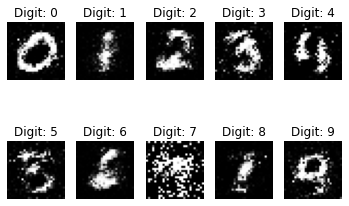

1401 [D loss: 0.705324, acc.: 54.69%] [G loss: 1.191209]
1402 [D loss: 0.694134, acc.: 54.69%] [G loss: 1.153701]
1403 [D loss: 0.597161, acc.: 70.31%] [G loss: 1.070137]
1404 [D loss: 0.615115, acc.: 65.62%] [G loss: 1.015117]
1405 [D loss: 0.666455, acc.: 60.94%] [G loss: 1.121880]
1406 [D loss: 0.630358, acc.: 60.94%] [G loss: 1.122321]
1407 [D loss: 0.615859, acc.: 65.62%] [G loss: 1.016992]
1408 [D loss: 0.631584, acc.: 60.94%] [G loss: 1.037539]
1409 [D loss: 0.582224, acc.: 68.75%] [G loss: 0.965483]
1410 [D loss: 0.673519, acc.: 59.38%] [G loss: 1.025508]
1411 [D loss: 0.600922, acc.: 70.31%] [G loss: 0.967870]
1412 [D loss: 0.666072, acc.: 57.81%] [G loss: 0.989020]
1413 [D loss: 0.598744, acc.: 68.75%] [G loss: 1.142791]
1414 [D loss: 0.619829, acc.: 68.75%] [G loss: 0.965970]
1415 [D loss: 0.707516, acc.: 50.00%] [G loss: 1.058287]
1416 [D loss: 0.640071, acc.: 64.06%] [G loss: 1.106836]
1417 [D loss: 0.672898, acc.: 60.94%] [G loss: 1.044180]
1418 [D loss: 0.600227, acc.: 6

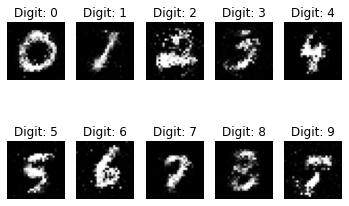

1601 [D loss: 0.677428, acc.: 56.25%] [G loss: 1.165897]
1602 [D loss: 0.611725, acc.: 62.50%] [G loss: 0.984137]
1603 [D loss: 0.674540, acc.: 56.25%] [G loss: 1.045197]
1604 [D loss: 0.618487, acc.: 64.06%] [G loss: 1.021350]
1605 [D loss: 0.595646, acc.: 65.62%] [G loss: 1.081472]
1606 [D loss: 0.700093, acc.: 59.38%] [G loss: 1.048395]
1607 [D loss: 0.680687, acc.: 62.50%] [G loss: 0.931748]
1608 [D loss: 0.721457, acc.: 51.56%] [G loss: 1.075609]
1609 [D loss: 0.759866, acc.: 56.25%] [G loss: 1.034096]
1610 [D loss: 0.735517, acc.: 50.00%] [G loss: 1.110027]
1611 [D loss: 0.654281, acc.: 62.50%] [G loss: 1.036165]
1612 [D loss: 0.617670, acc.: 59.38%] [G loss: 1.029593]
1613 [D loss: 0.644506, acc.: 60.94%] [G loss: 1.017339]
1614 [D loss: 0.694473, acc.: 57.81%] [G loss: 1.064681]
1615 [D loss: 0.734093, acc.: 51.56%] [G loss: 0.927354]
1616 [D loss: 0.591242, acc.: 68.75%] [G loss: 0.932747]
1617 [D loss: 0.638284, acc.: 65.62%] [G loss: 0.907329]
1618 [D loss: 0.699367, acc.: 5

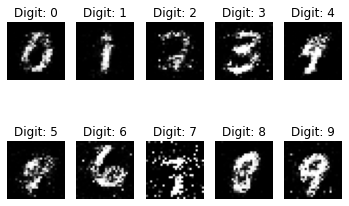

1801 [D loss: 0.717795, acc.: 45.31%] [G loss: 0.963465]
1802 [D loss: 0.666678, acc.: 57.81%] [G loss: 0.961865]
1803 [D loss: 0.704080, acc.: 53.12%] [G loss: 0.996445]
1804 [D loss: 0.666938, acc.: 56.25%] [G loss: 0.947757]
1805 [D loss: 0.640609, acc.: 57.81%] [G loss: 1.011641]
1806 [D loss: 0.641225, acc.: 64.06%] [G loss: 0.909318]
1807 [D loss: 0.611219, acc.: 75.00%] [G loss: 0.861601]
1808 [D loss: 0.657232, acc.: 64.06%] [G loss: 0.921844]
1809 [D loss: 0.614665, acc.: 67.19%] [G loss: 0.876170]
1810 [D loss: 0.642342, acc.: 60.94%] [G loss: 0.953376]
1811 [D loss: 0.701118, acc.: 57.81%] [G loss: 0.897912]
1812 [D loss: 0.626148, acc.: 57.81%] [G loss: 0.890841]
1813 [D loss: 0.667717, acc.: 65.62%] [G loss: 0.934520]
1814 [D loss: 0.724746, acc.: 54.69%] [G loss: 0.944029]
1815 [D loss: 0.694121, acc.: 60.94%] [G loss: 0.931949]
1816 [D loss: 0.631040, acc.: 65.62%] [G loss: 1.066797]
1817 [D loss: 0.758376, acc.: 42.19%] [G loss: 1.017519]
1818 [D loss: 0.694300, acc.: 5

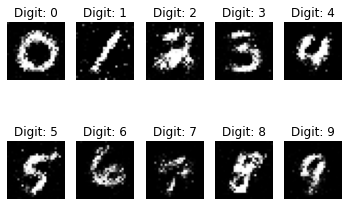

2001 [D loss: 0.713326, acc.: 51.56%] [G loss: 0.900872]
2002 [D loss: 0.639439, acc.: 62.50%] [G loss: 0.939237]
2003 [D loss: 0.651597, acc.: 56.25%] [G loss: 0.886624]
2004 [D loss: 0.606528, acc.: 67.19%] [G loss: 0.870420]
2005 [D loss: 0.701652, acc.: 50.00%] [G loss: 0.905367]
2006 [D loss: 0.689735, acc.: 50.00%] [G loss: 0.973684]
2007 [D loss: 0.663856, acc.: 59.38%] [G loss: 1.005192]
2008 [D loss: 0.679948, acc.: 57.81%] [G loss: 0.962705]
2009 [D loss: 0.640792, acc.: 56.25%] [G loss: 0.894630]
2010 [D loss: 0.680357, acc.: 51.56%] [G loss: 0.798369]
2011 [D loss: 0.622728, acc.: 67.19%] [G loss: 0.857827]
2012 [D loss: 0.645370, acc.: 60.94%] [G loss: 0.833878]
2013 [D loss: 0.707882, acc.: 48.44%] [G loss: 0.938070]
2014 [D loss: 0.659823, acc.: 57.81%] [G loss: 0.790554]
2015 [D loss: 0.693811, acc.: 53.12%] [G loss: 0.923380]
2016 [D loss: 0.654936, acc.: 65.62%] [G loss: 1.005447]
2017 [D loss: 0.648852, acc.: 59.38%] [G loss: 0.911944]
2018 [D loss: 0.674614, acc.: 6

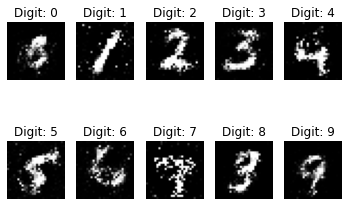

2201 [D loss: 0.669307, acc.: 64.06%] [G loss: 0.878048]
2202 [D loss: 0.641063, acc.: 62.50%] [G loss: 0.889109]
2203 [D loss: 0.657945, acc.: 65.62%] [G loss: 0.844049]
2204 [D loss: 0.639829, acc.: 64.06%] [G loss: 0.898800]
2205 [D loss: 0.685396, acc.: 56.25%] [G loss: 0.890993]
2206 [D loss: 0.688620, acc.: 54.69%] [G loss: 0.822438]
2207 [D loss: 0.654028, acc.: 60.94%] [G loss: 0.881852]
2208 [D loss: 0.700173, acc.: 51.56%] [G loss: 0.944919]
2209 [D loss: 0.683276, acc.: 50.00%] [G loss: 0.858571]
2210 [D loss: 0.684991, acc.: 53.12%] [G loss: 0.850269]
2211 [D loss: 0.661871, acc.: 57.81%] [G loss: 0.900290]
2212 [D loss: 0.639660, acc.: 60.94%] [G loss: 0.885686]
2213 [D loss: 0.667405, acc.: 59.38%] [G loss: 0.909653]
2214 [D loss: 0.669427, acc.: 57.81%] [G loss: 0.833817]
2215 [D loss: 0.770404, acc.: 42.19%] [G loss: 0.806877]
2216 [D loss: 0.720474, acc.: 53.12%] [G loss: 0.880911]
2217 [D loss: 0.649729, acc.: 60.94%] [G loss: 0.831758]
2218 [D loss: 0.675018, acc.: 5

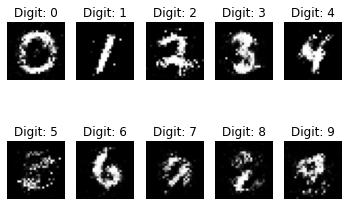

2401 [D loss: 0.636351, acc.: 64.06%] [G loss: 0.888179]
2402 [D loss: 0.642030, acc.: 60.94%] [G loss: 0.859658]
2403 [D loss: 0.653625, acc.: 65.62%] [G loss: 0.836527]
2404 [D loss: 0.642839, acc.: 59.38%] [G loss: 0.796232]
2405 [D loss: 0.647846, acc.: 56.25%] [G loss: 0.856672]
2406 [D loss: 0.632810, acc.: 56.25%] [G loss: 0.832074]
2407 [D loss: 0.643322, acc.: 60.94%] [G loss: 0.822972]
2408 [D loss: 0.643426, acc.: 56.25%] [G loss: 0.830923]
2409 [D loss: 0.619657, acc.: 68.75%] [G loss: 0.858138]
2410 [D loss: 0.629290, acc.: 60.94%] [G loss: 0.868210]
2411 [D loss: 0.650959, acc.: 57.81%] [G loss: 0.850245]
2412 [D loss: 0.686041, acc.: 51.56%] [G loss: 0.947367]
2413 [D loss: 0.631960, acc.: 62.50%] [G loss: 0.878361]
2414 [D loss: 0.652812, acc.: 59.38%] [G loss: 0.869147]
2415 [D loss: 0.708240, acc.: 50.00%] [G loss: 0.865971]
2416 [D loss: 0.616049, acc.: 64.06%] [G loss: 0.831042]
2417 [D loss: 0.677254, acc.: 59.38%] [G loss: 0.861110]
2418 [D loss: 0.645952, acc.: 6

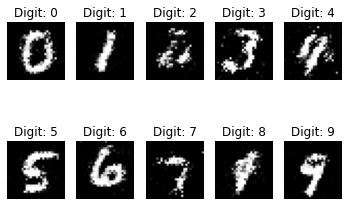

2601 [D loss: 0.680724, acc.: 60.94%] [G loss: 0.890792]
2602 [D loss: 0.590681, acc.: 71.88%] [G loss: 0.812442]
2603 [D loss: 0.596908, acc.: 67.19%] [G loss: 0.880868]
2604 [D loss: 0.676715, acc.: 53.12%] [G loss: 0.839324]
2605 [D loss: 0.668951, acc.: 60.94%] [G loss: 0.859189]
2606 [D loss: 0.663525, acc.: 64.06%] [G loss: 0.822117]
2607 [D loss: 0.696886, acc.: 51.56%] [G loss: 0.842364]
2608 [D loss: 0.670896, acc.: 54.69%] [G loss: 0.900999]
2609 [D loss: 0.661861, acc.: 54.69%] [G loss: 0.870958]
2610 [D loss: 0.656554, acc.: 51.56%] [G loss: 0.793044]
2611 [D loss: 0.702600, acc.: 56.25%] [G loss: 0.870769]
2612 [D loss: 0.635290, acc.: 64.06%] [G loss: 0.926874]
2613 [D loss: 0.675967, acc.: 53.12%] [G loss: 0.866789]
2614 [D loss: 0.724880, acc.: 50.00%] [G loss: 0.888895]
2615 [D loss: 0.649798, acc.: 62.50%] [G loss: 0.875489]
2616 [D loss: 0.685408, acc.: 51.56%] [G loss: 0.819013]
2617 [D loss: 0.650761, acc.: 59.38%] [G loss: 0.904663]
2618 [D loss: 0.671303, acc.: 5

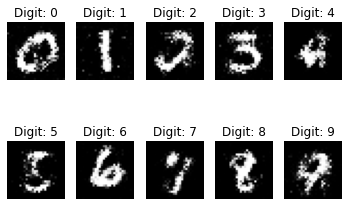

2801 [D loss: 0.689601, acc.: 56.25%] [G loss: 0.824410]
2802 [D loss: 0.679315, acc.: 54.69%] [G loss: 0.833941]
2803 [D loss: 0.665492, acc.: 57.81%] [G loss: 0.814647]
2804 [D loss: 0.669379, acc.: 64.06%] [G loss: 0.828374]
2805 [D loss: 0.633822, acc.: 64.06%] [G loss: 0.808228]
2806 [D loss: 0.704870, acc.: 51.56%] [G loss: 0.829618]
2807 [D loss: 0.661004, acc.: 62.50%] [G loss: 0.849505]
2808 [D loss: 0.683114, acc.: 56.25%] [G loss: 0.792346]
2809 [D loss: 0.681032, acc.: 59.38%] [G loss: 0.794033]
2810 [D loss: 0.652456, acc.: 54.69%] [G loss: 0.822299]
2811 [D loss: 0.644268, acc.: 60.94%] [G loss: 0.777802]
2812 [D loss: 0.673868, acc.: 51.56%] [G loss: 0.829870]
2813 [D loss: 0.684244, acc.: 54.69%] [G loss: 0.842782]
2814 [D loss: 0.605910, acc.: 70.31%] [G loss: 0.811944]
2815 [D loss: 0.617301, acc.: 60.94%] [G loss: 0.769043]
2816 [D loss: 0.624510, acc.: 62.50%] [G loss: 0.833336]
2817 [D loss: 0.675143, acc.: 51.56%] [G loss: 0.814763]
2818 [D loss: 0.634883, acc.: 6

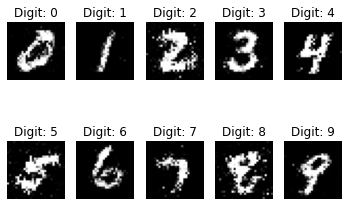

3001 [D loss: 0.648437, acc.: 62.50%] [G loss: 0.892203]
3002 [D loss: 0.663538, acc.: 53.12%] [G loss: 0.828067]
3003 [D loss: 0.681513, acc.: 54.69%] [G loss: 0.869537]
3004 [D loss: 0.684783, acc.: 56.25%] [G loss: 0.828199]
3005 [D loss: 0.619675, acc.: 64.06%] [G loss: 0.905800]
3006 [D loss: 0.670443, acc.: 54.69%] [G loss: 0.907124]
3007 [D loss: 0.650402, acc.: 64.06%] [G loss: 0.875042]
3008 [D loss: 0.646363, acc.: 62.50%] [G loss: 0.886718]
3009 [D loss: 0.699955, acc.: 53.12%] [G loss: 0.835874]
3010 [D loss: 0.713592, acc.: 51.56%] [G loss: 0.896194]
3011 [D loss: 0.638509, acc.: 57.81%] [G loss: 0.895105]
3012 [D loss: 0.660474, acc.: 60.94%] [G loss: 0.924620]
3013 [D loss: 0.625646, acc.: 59.38%] [G loss: 0.839725]
3014 [D loss: 0.665043, acc.: 60.94%] [G loss: 0.864618]
3015 [D loss: 0.643095, acc.: 64.06%] [G loss: 0.880378]
3016 [D loss: 0.656389, acc.: 62.50%] [G loss: 0.846447]
3017 [D loss: 0.665319, acc.: 53.12%] [G loss: 0.828669]
3018 [D loss: 0.698439, acc.: 5

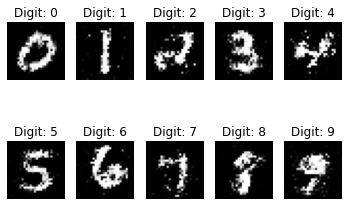

3201 [D loss: 0.653262, acc.: 53.12%] [G loss: 0.793096]
3202 [D loss: 0.687058, acc.: 50.00%] [G loss: 0.787319]
3203 [D loss: 0.671290, acc.: 57.81%] [G loss: 0.866192]
3204 [D loss: 0.677522, acc.: 60.94%] [G loss: 0.803694]
3205 [D loss: 0.690039, acc.: 56.25%] [G loss: 0.881186]
3206 [D loss: 0.657622, acc.: 56.25%] [G loss: 0.807941]
3207 [D loss: 0.628149, acc.: 67.19%] [G loss: 0.771267]
3208 [D loss: 0.692612, acc.: 45.31%] [G loss: 0.837564]
3209 [D loss: 0.630724, acc.: 62.50%] [G loss: 0.829303]
3210 [D loss: 0.674735, acc.: 53.12%] [G loss: 0.846349]
3211 [D loss: 0.685546, acc.: 56.25%] [G loss: 0.791114]
3212 [D loss: 0.682274, acc.: 54.69%] [G loss: 0.798571]
3213 [D loss: 0.652172, acc.: 68.75%] [G loss: 0.811978]
3214 [D loss: 0.677850, acc.: 56.25%] [G loss: 0.828130]
3215 [D loss: 0.679384, acc.: 54.69%] [G loss: 0.837090]
3216 [D loss: 0.682496, acc.: 53.12%] [G loss: 0.821112]
3217 [D loss: 0.691925, acc.: 53.12%] [G loss: 0.832926]
3218 [D loss: 0.694865, acc.: 5

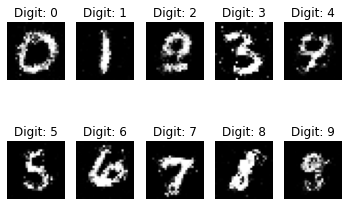

3401 [D loss: 0.669853, acc.: 59.38%] [G loss: 0.841466]
3402 [D loss: 0.708336, acc.: 56.25%] [G loss: 0.805418]
3403 [D loss: 0.630078, acc.: 57.81%] [G loss: 0.783404]
3404 [D loss: 0.667934, acc.: 53.12%] [G loss: 0.804122]
3405 [D loss: 0.653466, acc.: 62.50%] [G loss: 0.811363]
3406 [D loss: 0.632383, acc.: 65.62%] [G loss: 0.757285]
3407 [D loss: 0.716897, acc.: 50.00%] [G loss: 0.830931]
3408 [D loss: 0.680900, acc.: 50.00%] [G loss: 0.832463]
3409 [D loss: 0.657257, acc.: 59.38%] [G loss: 0.893177]
3410 [D loss: 0.661877, acc.: 56.25%] [G loss: 0.823383]
3411 [D loss: 0.730631, acc.: 51.56%] [G loss: 0.818679]
3412 [D loss: 0.674215, acc.: 56.25%] [G loss: 0.839399]
3413 [D loss: 0.702365, acc.: 54.69%] [G loss: 0.799990]
3414 [D loss: 0.671056, acc.: 54.69%] [G loss: 0.819221]
3415 [D loss: 0.674453, acc.: 59.38%] [G loss: 0.856530]
3416 [D loss: 0.640459, acc.: 64.06%] [G loss: 0.842669]
3417 [D loss: 0.673711, acc.: 54.69%] [G loss: 0.812363]
3418 [D loss: 0.707140, acc.: 4

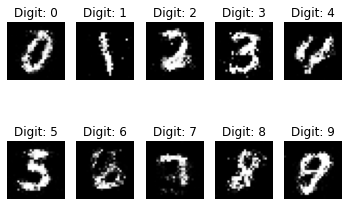

3601 [D loss: 0.711716, acc.: 51.56%] [G loss: 0.826337]
3602 [D loss: 0.712876, acc.: 50.00%] [G loss: 0.793661]
3603 [D loss: 0.668945, acc.: 60.94%] [G loss: 0.820041]
3604 [D loss: 0.697237, acc.: 48.44%] [G loss: 0.803803]
3605 [D loss: 0.664499, acc.: 53.12%] [G loss: 0.830061]
3606 [D loss: 0.628003, acc.: 65.62%] [G loss: 0.797294]
3607 [D loss: 0.671013, acc.: 54.69%] [G loss: 0.770457]
3608 [D loss: 0.650562, acc.: 65.62%] [G loss: 0.785301]
3609 [D loss: 0.725310, acc.: 48.44%] [G loss: 0.791308]
3610 [D loss: 0.637996, acc.: 64.06%] [G loss: 0.802709]
3611 [D loss: 0.676698, acc.: 53.12%] [G loss: 0.796843]
3612 [D loss: 0.704464, acc.: 54.69%] [G loss: 0.779541]
3613 [D loss: 0.668276, acc.: 68.75%] [G loss: 0.835926]
3614 [D loss: 0.641941, acc.: 59.38%] [G loss: 0.798301]
3615 [D loss: 0.669297, acc.: 56.25%] [G loss: 0.888731]
3616 [D loss: 0.707375, acc.: 51.56%] [G loss: 0.838848]
3617 [D loss: 0.675931, acc.: 56.25%] [G loss: 0.835482]
3618 [D loss: 0.674258, acc.: 5

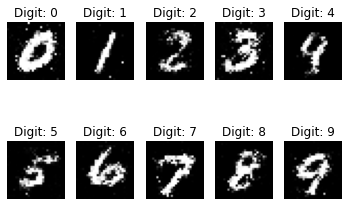

3801 [D loss: 0.650791, acc.: 62.50%] [G loss: 0.799326]
3802 [D loss: 0.683928, acc.: 51.56%] [G loss: 0.770321]
3803 [D loss: 0.682354, acc.: 56.25%] [G loss: 0.789486]
3804 [D loss: 0.675243, acc.: 59.38%] [G loss: 0.809078]
3805 [D loss: 0.692054, acc.: 60.94%] [G loss: 0.764131]
3806 [D loss: 0.662344, acc.: 53.12%] [G loss: 0.805954]
3807 [D loss: 0.661290, acc.: 59.38%] [G loss: 0.752933]
3808 [D loss: 0.679878, acc.: 64.06%] [G loss: 0.782572]
3809 [D loss: 0.706301, acc.: 48.44%] [G loss: 0.783573]
3810 [D loss: 0.729528, acc.: 51.56%] [G loss: 0.788382]
3811 [D loss: 0.673060, acc.: 59.38%] [G loss: 0.763702]
3812 [D loss: 0.724752, acc.: 45.31%] [G loss: 0.813137]
3813 [D loss: 0.650245, acc.: 62.50%] [G loss: 0.777614]
3814 [D loss: 0.710831, acc.: 50.00%] [G loss: 0.761841]
3815 [D loss: 0.705027, acc.: 46.88%] [G loss: 0.787842]
3816 [D loss: 0.686882, acc.: 59.38%] [G loss: 0.820541]
3817 [D loss: 0.687172, acc.: 59.38%] [G loss: 0.773993]
3818 [D loss: 0.735598, acc.: 4

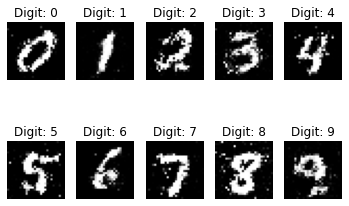

4001 [D loss: 0.680257, acc.: 53.12%] [G loss: 0.794555]
4002 [D loss: 0.699800, acc.: 48.44%] [G loss: 0.833424]
4003 [D loss: 0.710331, acc.: 45.31%] [G loss: 0.802053]
4004 [D loss: 0.679458, acc.: 57.81%] [G loss: 0.789333]
4005 [D loss: 0.682150, acc.: 53.12%] [G loss: 0.803080]
4006 [D loss: 0.715133, acc.: 51.56%] [G loss: 0.824926]
4007 [D loss: 0.659106, acc.: 68.75%] [G loss: 0.796320]
4008 [D loss: 0.758796, acc.: 43.75%] [G loss: 0.801332]
4009 [D loss: 0.679113, acc.: 57.81%] [G loss: 0.788209]
4010 [D loss: 0.676160, acc.: 56.25%] [G loss: 0.858801]
4011 [D loss: 0.677030, acc.: 60.94%] [G loss: 0.832213]
4012 [D loss: 0.681277, acc.: 54.69%] [G loss: 0.842889]
4013 [D loss: 0.667659, acc.: 60.94%] [G loss: 0.813645]
4014 [D loss: 0.692440, acc.: 51.56%] [G loss: 0.781526]
4015 [D loss: 0.673893, acc.: 60.94%] [G loss: 0.758733]
4016 [D loss: 0.703406, acc.: 57.81%] [G loss: 0.801785]
4017 [D loss: 0.684550, acc.: 51.56%] [G loss: 0.792454]
4018 [D loss: 0.681950, acc.: 4

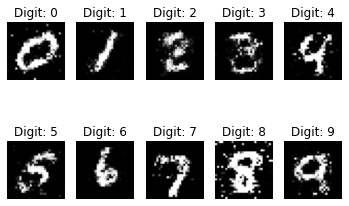

4201 [D loss: 0.640735, acc.: 60.94%] [G loss: 0.785021]
4202 [D loss: 0.635185, acc.: 60.94%] [G loss: 0.825675]
4203 [D loss: 0.658278, acc.: 56.25%] [G loss: 0.798442]
4204 [D loss: 0.704938, acc.: 57.81%] [G loss: 0.848622]
4205 [D loss: 0.684877, acc.: 56.25%] [G loss: 0.773699]
4206 [D loss: 0.657134, acc.: 60.94%] [G loss: 0.765570]
4207 [D loss: 0.647012, acc.: 59.38%] [G loss: 0.787216]
4208 [D loss: 0.679221, acc.: 59.38%] [G loss: 0.840586]
4209 [D loss: 0.627560, acc.: 64.06%] [G loss: 0.838247]
4210 [D loss: 0.665571, acc.: 59.38%] [G loss: 0.831878]
4211 [D loss: 0.669352, acc.: 51.56%] [G loss: 0.928368]
4212 [D loss: 0.680269, acc.: 56.25%] [G loss: 0.822584]
4213 [D loss: 0.632944, acc.: 62.50%] [G loss: 0.839257]
4214 [D loss: 0.692144, acc.: 60.94%] [G loss: 0.789654]
4215 [D loss: 0.711560, acc.: 57.81%] [G loss: 0.849524]
4216 [D loss: 0.699607, acc.: 51.56%] [G loss: 0.835146]
4217 [D loss: 0.650939, acc.: 67.19%] [G loss: 0.808722]
4218 [D loss: 0.672501, acc.: 6

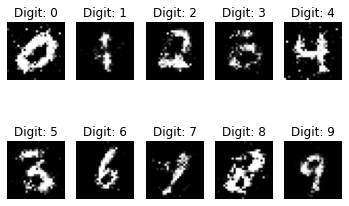

4401 [D loss: 0.667970, acc.: 57.81%] [G loss: 0.846652]
4402 [D loss: 0.683628, acc.: 54.69%] [G loss: 0.840001]
4403 [D loss: 0.646291, acc.: 62.50%] [G loss: 0.808153]
4404 [D loss: 0.648648, acc.: 62.50%] [G loss: 0.821065]
4405 [D loss: 0.653953, acc.: 59.38%] [G loss: 0.815705]
4406 [D loss: 0.660540, acc.: 51.56%] [G loss: 0.804690]
4407 [D loss: 0.721092, acc.: 62.50%] [G loss: 0.797046]
4408 [D loss: 0.652255, acc.: 54.69%] [G loss: 0.760269]
4409 [D loss: 0.664436, acc.: 51.56%] [G loss: 0.769062]
4410 [D loss: 0.647148, acc.: 67.19%] [G loss: 0.786435]
4411 [D loss: 0.671885, acc.: 57.81%] [G loss: 0.802019]
4412 [D loss: 0.663924, acc.: 60.94%] [G loss: 0.787598]
4413 [D loss: 0.655100, acc.: 59.38%] [G loss: 0.732734]
4414 [D loss: 0.623783, acc.: 62.50%] [G loss: 0.852525]
4415 [D loss: 0.668492, acc.: 60.94%] [G loss: 0.784284]
4416 [D loss: 0.657189, acc.: 62.50%] [G loss: 0.819629]
4417 [D loss: 0.696584, acc.: 46.88%] [G loss: 0.771221]
4418 [D loss: 0.688354, acc.: 5

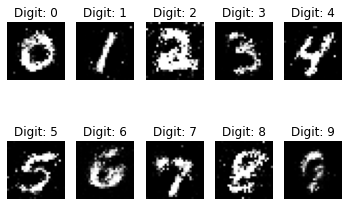

4601 [D loss: 0.645255, acc.: 54.69%] [G loss: 0.817068]
4602 [D loss: 0.661842, acc.: 59.38%] [G loss: 0.803436]
4603 [D loss: 0.642207, acc.: 57.81%] [G loss: 0.815372]
4604 [D loss: 0.678481, acc.: 50.00%] [G loss: 0.830399]
4605 [D loss: 0.672411, acc.: 59.38%] [G loss: 0.827758]
4606 [D loss: 0.663808, acc.: 54.69%] [G loss: 0.788519]
4607 [D loss: 0.664045, acc.: 57.81%] [G loss: 0.800890]
4608 [D loss: 0.664196, acc.: 62.50%] [G loss: 0.821702]
4609 [D loss: 0.695728, acc.: 54.69%] [G loss: 0.857124]
4610 [D loss: 0.632482, acc.: 62.50%] [G loss: 0.868479]
4611 [D loss: 0.657876, acc.: 65.62%] [G loss: 0.857587]
4612 [D loss: 0.687775, acc.: 60.94%] [G loss: 0.841143]
4613 [D loss: 0.687557, acc.: 48.44%] [G loss: 0.813103]
4614 [D loss: 0.729321, acc.: 51.56%] [G loss: 0.846240]
4615 [D loss: 0.671691, acc.: 62.50%] [G loss: 0.827268]
4616 [D loss: 0.693081, acc.: 53.12%] [G loss: 0.864217]
4617 [D loss: 0.630628, acc.: 71.88%] [G loss: 0.838976]
4618 [D loss: 0.712729, acc.: 5

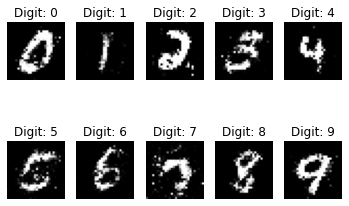

4801 [D loss: 0.695236, acc.: 54.69%] [G loss: 0.789338]
4802 [D loss: 0.684655, acc.: 53.12%] [G loss: 0.737886]
4803 [D loss: 0.657825, acc.: 56.25%] [G loss: 0.805780]
4804 [D loss: 0.700870, acc.: 53.12%] [G loss: 0.764047]
4805 [D loss: 0.661291, acc.: 62.50%] [G loss: 0.804973]
4806 [D loss: 0.666940, acc.: 54.69%] [G loss: 0.813547]
4807 [D loss: 0.672163, acc.: 59.38%] [G loss: 0.779144]
4808 [D loss: 0.657394, acc.: 57.81%] [G loss: 0.796201]
4809 [D loss: 0.661395, acc.: 53.12%] [G loss: 0.779672]
4810 [D loss: 0.665432, acc.: 56.25%] [G loss: 0.787516]
4811 [D loss: 0.688492, acc.: 59.38%] [G loss: 0.812031]
4812 [D loss: 0.662991, acc.: 53.12%] [G loss: 0.747767]
4813 [D loss: 0.650353, acc.: 62.50%] [G loss: 0.784904]
4814 [D loss: 0.666919, acc.: 56.25%] [G loss: 0.809281]
4815 [D loss: 0.671002, acc.: 46.88%] [G loss: 0.802563]
4816 [D loss: 0.653654, acc.: 67.19%] [G loss: 0.780370]
4817 [D loss: 0.591571, acc.: 64.06%] [G loss: 0.793458]
4818 [D loss: 0.718423, acc.: 5

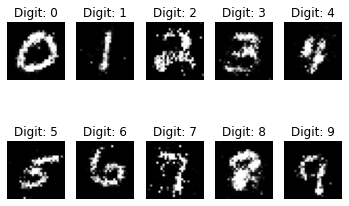

5001 [D loss: 0.659469, acc.: 57.81%] [G loss: 0.813499]
5002 [D loss: 0.669095, acc.: 54.69%] [G loss: 0.785091]
5003 [D loss: 0.688961, acc.: 59.38%] [G loss: 0.775195]
5004 [D loss: 0.660142, acc.: 67.19%] [G loss: 0.798547]
5005 [D loss: 0.679974, acc.: 59.38%] [G loss: 0.822733]
5006 [D loss: 0.707639, acc.: 57.81%] [G loss: 0.799525]
5007 [D loss: 0.678882, acc.: 57.81%] [G loss: 0.733860]
5008 [D loss: 0.630397, acc.: 70.31%] [G loss: 0.806666]
5009 [D loss: 0.643197, acc.: 50.00%] [G loss: 0.738907]
5010 [D loss: 0.681622, acc.: 57.81%] [G loss: 0.774264]
5011 [D loss: 0.680708, acc.: 59.38%] [G loss: 0.782545]
5012 [D loss: 0.662313, acc.: 57.81%] [G loss: 0.807938]
5013 [D loss: 0.690606, acc.: 57.81%] [G loss: 0.793125]
5014 [D loss: 0.652413, acc.: 60.94%] [G loss: 0.797930]
5015 [D loss: 0.690140, acc.: 54.69%] [G loss: 0.763500]
5016 [D loss: 0.694420, acc.: 54.69%] [G loss: 0.814177]
5017 [D loss: 0.643131, acc.: 64.06%] [G loss: 0.792406]
5018 [D loss: 0.649122, acc.: 5

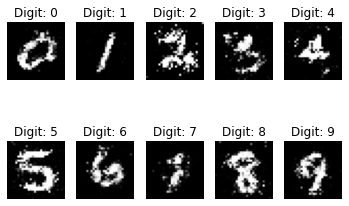

5201 [D loss: 0.669903, acc.: 53.12%] [G loss: 0.735615]
5202 [D loss: 0.638339, acc.: 57.81%] [G loss: 0.749868]
5203 [D loss: 0.656740, acc.: 67.19%] [G loss: 0.782156]
5204 [D loss: 0.649254, acc.: 51.56%] [G loss: 0.805153]
5205 [D loss: 0.651355, acc.: 57.81%] [G loss: 0.792321]
5206 [D loss: 0.639296, acc.: 59.38%] [G loss: 0.816082]
5207 [D loss: 0.680801, acc.: 60.94%] [G loss: 0.781455]
5208 [D loss: 0.670170, acc.: 53.12%] [G loss: 0.797686]
5209 [D loss: 0.678475, acc.: 57.81%] [G loss: 0.802236]
5210 [D loss: 0.658006, acc.: 60.94%] [G loss: 0.843797]
5211 [D loss: 0.703852, acc.: 51.56%] [G loss: 0.784456]
5212 [D loss: 0.642742, acc.: 65.62%] [G loss: 0.855455]
5213 [D loss: 0.679173, acc.: 56.25%] [G loss: 0.792144]
5214 [D loss: 0.674542, acc.: 48.44%] [G loss: 0.813923]
5215 [D loss: 0.627608, acc.: 60.94%] [G loss: 0.836331]
5216 [D loss: 0.633078, acc.: 64.06%] [G loss: 0.814052]
5217 [D loss: 0.675347, acc.: 59.38%] [G loss: 0.839396]
5218 [D loss: 0.637589, acc.: 6

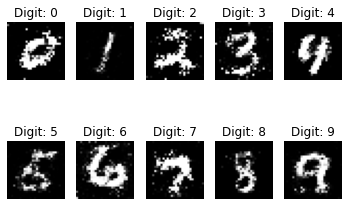

5401 [D loss: 0.661094, acc.: 60.94%] [G loss: 0.825214]
5402 [D loss: 0.674419, acc.: 50.00%] [G loss: 0.782249]
5403 [D loss: 0.662308, acc.: 53.12%] [G loss: 0.836328]
5404 [D loss: 0.654438, acc.: 62.50%] [G loss: 0.805732]
5405 [D loss: 0.740986, acc.: 50.00%] [G loss: 0.795794]
5406 [D loss: 0.677004, acc.: 51.56%] [G loss: 0.829284]
5407 [D loss: 0.665940, acc.: 56.25%] [G loss: 0.815394]
5408 [D loss: 0.713167, acc.: 50.00%] [G loss: 0.778017]
5409 [D loss: 0.660742, acc.: 62.50%] [G loss: 0.860120]
5410 [D loss: 0.757660, acc.: 46.88%] [G loss: 0.812513]
5411 [D loss: 0.690060, acc.: 59.38%] [G loss: 0.788012]
5412 [D loss: 0.688491, acc.: 59.38%] [G loss: 0.798125]
5413 [D loss: 0.693516, acc.: 50.00%] [G loss: 0.784352]
5414 [D loss: 0.673387, acc.: 60.94%] [G loss: 0.833557]
5415 [D loss: 0.719721, acc.: 46.88%] [G loss: 0.760550]
5416 [D loss: 0.654781, acc.: 62.50%] [G loss: 0.798404]
5417 [D loss: 0.705515, acc.: 53.12%] [G loss: 0.763442]
5418 [D loss: 0.709135, acc.: 5

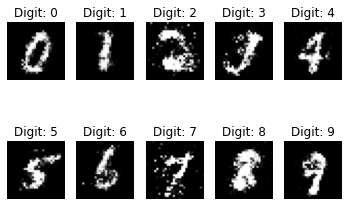

5601 [D loss: 0.680990, acc.: 50.00%] [G loss: 0.789134]
5602 [D loss: 0.715119, acc.: 56.25%] [G loss: 0.797772]
5603 [D loss: 0.671234, acc.: 54.69%] [G loss: 0.752576]
5604 [D loss: 0.651787, acc.: 56.25%] [G loss: 0.767704]
5605 [D loss: 0.699125, acc.: 51.56%] [G loss: 0.775039]
5606 [D loss: 0.672526, acc.: 60.94%] [G loss: 0.789660]
5607 [D loss: 0.717758, acc.: 57.81%] [G loss: 0.787017]
5608 [D loss: 0.690840, acc.: 51.56%] [G loss: 0.792928]
5609 [D loss: 0.687616, acc.: 51.56%] [G loss: 0.801875]
5610 [D loss: 0.683332, acc.: 56.25%] [G loss: 0.770409]
5611 [D loss: 0.690288, acc.: 53.12%] [G loss: 0.778499]
5612 [D loss: 0.703013, acc.: 59.38%] [G loss: 0.804212]
5613 [D loss: 0.684706, acc.: 56.25%] [G loss: 0.781592]
5614 [D loss: 0.669468, acc.: 54.69%] [G loss: 0.812833]
5615 [D loss: 0.650239, acc.: 59.38%] [G loss: 0.781887]
5616 [D loss: 0.683124, acc.: 53.12%] [G loss: 0.778931]
5617 [D loss: 0.640811, acc.: 68.75%] [G loss: 0.810904]
5618 [D loss: 0.632195, acc.: 6

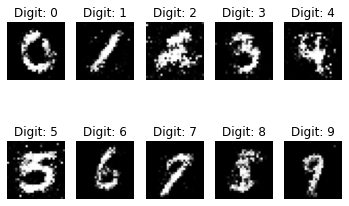

5801 [D loss: 0.673841, acc.: 50.00%] [G loss: 0.752887]
5802 [D loss: 0.738089, acc.: 45.31%] [G loss: 0.798272]
5803 [D loss: 0.654850, acc.: 64.06%] [G loss: 0.773200]
5804 [D loss: 0.668364, acc.: 48.44%] [G loss: 0.799260]
5805 [D loss: 0.662464, acc.: 64.06%] [G loss: 0.780595]
5806 [D loss: 0.688047, acc.: 53.12%] [G loss: 0.781125]
5807 [D loss: 0.666069, acc.: 56.25%] [G loss: 0.738931]
5808 [D loss: 0.687262, acc.: 57.81%] [G loss: 0.739410]
5809 [D loss: 0.665372, acc.: 62.50%] [G loss: 0.781369]
5810 [D loss: 0.693306, acc.: 48.44%] [G loss: 0.756010]
5811 [D loss: 0.667050, acc.: 62.50%] [G loss: 0.744465]
5812 [D loss: 0.673660, acc.: 53.12%] [G loss: 0.703265]
5813 [D loss: 0.681929, acc.: 48.44%] [G loss: 0.779773]
5814 [D loss: 0.655792, acc.: 60.94%] [G loss: 0.749044]
5815 [D loss: 0.667402, acc.: 48.44%] [G loss: 0.727539]
5816 [D loss: 0.670240, acc.: 62.50%] [G loss: 0.784775]
5817 [D loss: 0.681225, acc.: 60.94%] [G loss: 0.783662]
5818 [D loss: 0.676009, acc.: 5

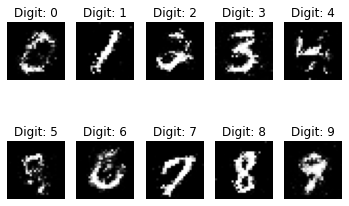

6001 [D loss: 0.659621, acc.: 56.25%] [G loss: 0.774932]
6002 [D loss: 0.701902, acc.: 50.00%] [G loss: 0.855816]
6003 [D loss: 0.695514, acc.: 48.44%] [G loss: 0.776044]
6004 [D loss: 0.641938, acc.: 57.81%] [G loss: 0.794535]
6005 [D loss: 0.697061, acc.: 53.12%] [G loss: 0.792625]
6006 [D loss: 0.703467, acc.: 46.88%] [G loss: 0.801649]
6007 [D loss: 0.710161, acc.: 46.88%] [G loss: 0.770678]
6008 [D loss: 0.692521, acc.: 50.00%] [G loss: 0.790744]
6009 [D loss: 0.657834, acc.: 57.81%] [G loss: 0.793746]
6010 [D loss: 0.637427, acc.: 62.50%] [G loss: 0.767595]
6011 [D loss: 0.653059, acc.: 64.06%] [G loss: 0.825538]
6012 [D loss: 0.668902, acc.: 67.19%] [G loss: 0.771761]
6013 [D loss: 0.703422, acc.: 48.44%] [G loss: 0.792560]
6014 [D loss: 0.704554, acc.: 43.75%] [G loss: 0.818824]
6015 [D loss: 0.688059, acc.: 45.31%] [G loss: 0.831740]
6016 [D loss: 0.703153, acc.: 46.88%] [G loss: 0.771885]
6017 [D loss: 0.667415, acc.: 51.56%] [G loss: 0.788554]
6018 [D loss: 0.675827, acc.: 5

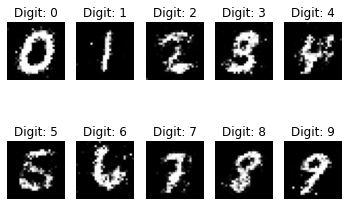

6201 [D loss: 0.643023, acc.: 56.25%] [G loss: 0.778964]
6202 [D loss: 0.627614, acc.: 70.31%] [G loss: 0.782239]
6203 [D loss: 0.638734, acc.: 59.38%] [G loss: 0.814617]
6204 [D loss: 0.654211, acc.: 64.06%] [G loss: 0.813787]
6205 [D loss: 0.701903, acc.: 54.69%] [G loss: 0.751223]
6206 [D loss: 0.676299, acc.: 59.38%] [G loss: 0.782589]
6207 [D loss: 0.654078, acc.: 56.25%] [G loss: 0.766656]
6208 [D loss: 0.689782, acc.: 48.44%] [G loss: 0.832505]
6209 [D loss: 0.656002, acc.: 64.06%] [G loss: 0.797202]
6210 [D loss: 0.657258, acc.: 59.38%] [G loss: 0.775657]
6211 [D loss: 0.701253, acc.: 51.56%] [G loss: 0.774485]
6212 [D loss: 0.675100, acc.: 53.12%] [G loss: 0.774209]
6213 [D loss: 0.710840, acc.: 42.19%] [G loss: 0.760238]
6214 [D loss: 0.710683, acc.: 45.31%] [G loss: 0.801901]
6215 [D loss: 0.645411, acc.: 53.12%] [G loss: 0.775942]
6216 [D loss: 0.698985, acc.: 46.88%] [G loss: 0.776895]
6217 [D loss: 0.643637, acc.: 51.56%] [G loss: 0.795534]
6218 [D loss: 0.682519, acc.: 5

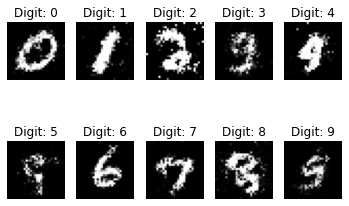

6401 [D loss: 0.668493, acc.: 59.38%] [G loss: 0.758992]
6402 [D loss: 0.668957, acc.: 67.19%] [G loss: 0.750110]
6403 [D loss: 0.636569, acc.: 73.44%] [G loss: 0.748233]
6404 [D loss: 0.674239, acc.: 56.25%] [G loss: 0.758565]
6405 [D loss: 0.656001, acc.: 67.19%] [G loss: 0.758358]
6406 [D loss: 0.683079, acc.: 56.25%] [G loss: 0.775563]
6407 [D loss: 0.697607, acc.: 54.69%] [G loss: 0.752574]
6408 [D loss: 0.670581, acc.: 54.69%] [G loss: 0.749814]
6409 [D loss: 0.679582, acc.: 57.81%] [G loss: 0.755293]
6410 [D loss: 0.692410, acc.: 56.25%] [G loss: 0.770141]
6411 [D loss: 0.636014, acc.: 70.31%] [G loss: 0.774494]
6412 [D loss: 0.709734, acc.: 53.12%] [G loss: 0.803125]
6413 [D loss: 0.646371, acc.: 64.06%] [G loss: 0.835896]
6414 [D loss: 0.696405, acc.: 46.88%] [G loss: 0.748224]
6415 [D loss: 0.659691, acc.: 50.00%] [G loss: 0.837080]
6416 [D loss: 0.650621, acc.: 64.06%] [G loss: 0.752005]
6417 [D loss: 0.724304, acc.: 50.00%] [G loss: 0.791792]
6418 [D loss: 0.662535, acc.: 6

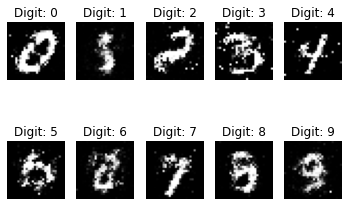

6601 [D loss: 0.691113, acc.: 56.25%] [G loss: 0.772807]
6602 [D loss: 0.689810, acc.: 50.00%] [G loss: 0.809135]
6603 [D loss: 0.642182, acc.: 59.38%] [G loss: 0.756043]
6604 [D loss: 0.682595, acc.: 59.38%] [G loss: 0.873273]
6605 [D loss: 0.727288, acc.: 45.31%] [G loss: 0.791189]
6606 [D loss: 0.684202, acc.: 57.81%] [G loss: 0.814688]
6607 [D loss: 0.722652, acc.: 46.88%] [G loss: 0.807610]
6608 [D loss: 0.670701, acc.: 51.56%] [G loss: 0.777399]
6609 [D loss: 0.704089, acc.: 56.25%] [G loss: 0.797991]
6610 [D loss: 0.666810, acc.: 57.81%] [G loss: 0.802346]
6611 [D loss: 0.674941, acc.: 54.69%] [G loss: 0.735323]
6612 [D loss: 0.667682, acc.: 56.25%] [G loss: 0.799490]
6613 [D loss: 0.663844, acc.: 60.94%] [G loss: 0.776663]
6614 [D loss: 0.701290, acc.: 57.81%] [G loss: 0.863029]
6615 [D loss: 0.688783, acc.: 53.12%] [G loss: 0.769974]
6616 [D loss: 0.651345, acc.: 73.44%] [G loss: 0.779260]
6617 [D loss: 0.719736, acc.: 42.19%] [G loss: 0.799458]
6618 [D loss: 0.671520, acc.: 5

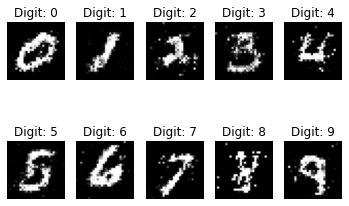

6801 [D loss: 0.613648, acc.: 65.62%] [G loss: 0.767803]
6802 [D loss: 0.683331, acc.: 51.56%] [G loss: 0.764916]
6803 [D loss: 0.642848, acc.: 59.38%] [G loss: 0.753335]
6804 [D loss: 0.731840, acc.: 48.44%] [G loss: 0.787125]
6805 [D loss: 0.686260, acc.: 56.25%] [G loss: 0.763036]
6806 [D loss: 0.641950, acc.: 62.50%] [G loss: 0.807499]
6807 [D loss: 0.667701, acc.: 57.81%] [G loss: 0.793934]
6808 [D loss: 0.659364, acc.: 62.50%] [G loss: 0.746495]
6809 [D loss: 0.689335, acc.: 50.00%] [G loss: 0.773173]
6810 [D loss: 0.656335, acc.: 57.81%] [G loss: 0.830638]
6811 [D loss: 0.667411, acc.: 50.00%] [G loss: 0.804780]
6812 [D loss: 0.672768, acc.: 51.56%] [G loss: 0.779421]
6813 [D loss: 0.710742, acc.: 46.88%] [G loss: 0.794255]
6814 [D loss: 0.677181, acc.: 60.94%] [G loss: 0.827146]
6815 [D loss: 0.642742, acc.: 67.19%] [G loss: 0.775051]
6816 [D loss: 0.709527, acc.: 60.94%] [G loss: 0.768870]
6817 [D loss: 0.634150, acc.: 62.50%] [G loss: 0.782126]
6818 [D loss: 0.660465, acc.: 5

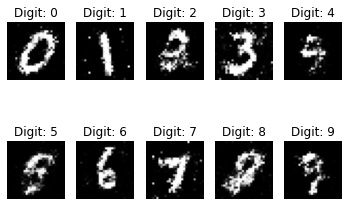

7001 [D loss: 0.683907, acc.: 50.00%] [G loss: 0.791178]
7002 [D loss: 0.722937, acc.: 56.25%] [G loss: 0.796824]
7003 [D loss: 0.680654, acc.: 51.56%] [G loss: 0.827370]
7004 [D loss: 0.647733, acc.: 57.81%] [G loss: 0.775267]
7005 [D loss: 0.686495, acc.: 57.81%] [G loss: 0.834520]
7006 [D loss: 0.688249, acc.: 57.81%] [G loss: 0.747446]
7007 [D loss: 0.642723, acc.: 62.50%] [G loss: 0.798036]
7008 [D loss: 0.717854, acc.: 43.75%] [G loss: 0.786953]
7009 [D loss: 0.665980, acc.: 67.19%] [G loss: 0.757652]
7010 [D loss: 0.729055, acc.: 42.19%] [G loss: 0.813639]
7011 [D loss: 0.683293, acc.: 51.56%] [G loss: 0.818410]
7012 [D loss: 0.625763, acc.: 64.06%] [G loss: 0.819578]
7013 [D loss: 0.680901, acc.: 57.81%] [G loss: 0.788075]
7014 [D loss: 0.663393, acc.: 64.06%] [G loss: 0.771816]
7015 [D loss: 0.642104, acc.: 67.19%] [G loss: 0.788474]
7016 [D loss: 0.725449, acc.: 48.44%] [G loss: 0.749794]
7017 [D loss: 0.666073, acc.: 60.94%] [G loss: 0.761946]
7018 [D loss: 0.692588, acc.: 5

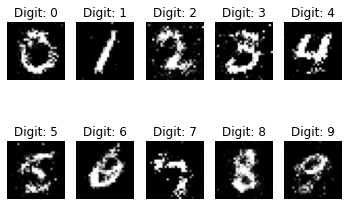

7201 [D loss: 0.643821, acc.: 60.94%] [G loss: 0.784000]
7202 [D loss: 0.718231, acc.: 43.75%] [G loss: 0.781689]
7203 [D loss: 0.637364, acc.: 62.50%] [G loss: 0.820880]
7204 [D loss: 0.679620, acc.: 59.38%] [G loss: 0.849094]
7205 [D loss: 0.684345, acc.: 62.50%] [G loss: 0.825730]
7206 [D loss: 0.684270, acc.: 59.38%] [G loss: 0.798779]
7207 [D loss: 0.703998, acc.: 48.44%] [G loss: 0.787947]
7208 [D loss: 0.652103, acc.: 62.50%] [G loss: 0.801394]
7209 [D loss: 0.670188, acc.: 56.25%] [G loss: 0.758598]
7210 [D loss: 0.696914, acc.: 50.00%] [G loss: 0.767195]
7211 [D loss: 0.633689, acc.: 67.19%] [G loss: 0.813084]
7212 [D loss: 0.680204, acc.: 50.00%] [G loss: 0.814063]
7213 [D loss: 0.724026, acc.: 46.88%] [G loss: 0.832597]
7214 [D loss: 0.673776, acc.: 50.00%] [G loss: 0.760784]
7215 [D loss: 0.658332, acc.: 59.38%] [G loss: 0.824015]
7216 [D loss: 0.680640, acc.: 57.81%] [G loss: 0.777153]
7217 [D loss: 0.669883, acc.: 60.94%] [G loss: 0.758869]
7218 [D loss: 0.705600, acc.: 4

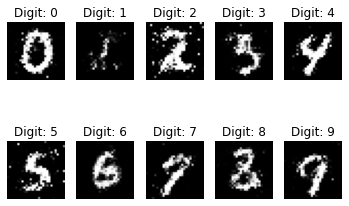

7401 [D loss: 0.719876, acc.: 46.88%] [G loss: 0.855694]
7402 [D loss: 0.669872, acc.: 64.06%] [G loss: 0.827541]
7403 [D loss: 0.674557, acc.: 53.12%] [G loss: 0.819740]
7404 [D loss: 0.676126, acc.: 54.69%] [G loss: 0.770593]
7405 [D loss: 0.665091, acc.: 59.38%] [G loss: 0.797973]
7406 [D loss: 0.656810, acc.: 64.06%] [G loss: 0.807282]
7407 [D loss: 0.705494, acc.: 54.69%] [G loss: 0.833219]
7408 [D loss: 0.647043, acc.: 70.31%] [G loss: 0.819029]
7409 [D loss: 0.682622, acc.: 62.50%] [G loss: 0.846300]
7410 [D loss: 0.677626, acc.: 59.38%] [G loss: 0.787112]
7411 [D loss: 0.635124, acc.: 73.44%] [G loss: 0.732928]
7412 [D loss: 0.688404, acc.: 60.94%] [G loss: 0.776625]
7413 [D loss: 0.680797, acc.: 48.44%] [G loss: 0.781695]
7414 [D loss: 0.661418, acc.: 60.94%] [G loss: 0.820284]
7415 [D loss: 0.665836, acc.: 51.56%] [G loss: 0.827202]
7416 [D loss: 0.652208, acc.: 56.25%] [G loss: 0.843296]
7417 [D loss: 0.656065, acc.: 67.19%] [G loss: 0.813941]
7418 [D loss: 0.644067, acc.: 6

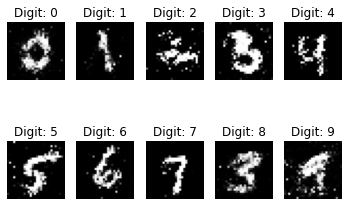

7601 [D loss: 0.658860, acc.: 53.12%] [G loss: 0.802131]
7602 [D loss: 0.688133, acc.: 53.12%] [G loss: 0.786119]
7603 [D loss: 0.681823, acc.: 54.69%] [G loss: 0.789732]
7604 [D loss: 0.615030, acc.: 70.31%] [G loss: 0.743622]
7605 [D loss: 0.665676, acc.: 57.81%] [G loss: 0.768292]
7606 [D loss: 0.640481, acc.: 60.94%] [G loss: 0.751196]
7607 [D loss: 0.674297, acc.: 60.94%] [G loss: 0.826401]
7608 [D loss: 0.626173, acc.: 60.94%] [G loss: 0.827752]
7609 [D loss: 0.679319, acc.: 56.25%] [G loss: 0.798145]
7610 [D loss: 0.686655, acc.: 48.44%] [G loss: 0.800059]
7611 [D loss: 0.659347, acc.: 60.94%] [G loss: 0.816588]
7612 [D loss: 0.686363, acc.: 57.81%] [G loss: 0.896306]
7613 [D loss: 0.622520, acc.: 64.06%] [G loss: 0.867783]
7614 [D loss: 0.668479, acc.: 65.62%] [G loss: 0.847480]
7615 [D loss: 0.620819, acc.: 65.62%] [G loss: 0.841821]
7616 [D loss: 0.692393, acc.: 46.88%] [G loss: 0.825930]
7617 [D loss: 0.679163, acc.: 56.25%] [G loss: 0.808845]
7618 [D loss: 0.661204, acc.: 6

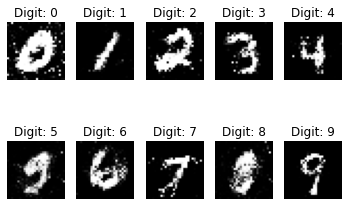

7801 [D loss: 0.663991, acc.: 62.50%] [G loss: 0.763135]
7802 [D loss: 0.654306, acc.: 56.25%] [G loss: 0.763150]
7803 [D loss: 0.682792, acc.: 59.38%] [G loss: 0.747768]
7804 [D loss: 0.680946, acc.: 54.69%] [G loss: 0.731829]
7805 [D loss: 0.707203, acc.: 51.56%] [G loss: 0.744019]
7806 [D loss: 0.659172, acc.: 60.94%] [G loss: 0.765961]
7807 [D loss: 0.684737, acc.: 53.12%] [G loss: 0.758654]
7808 [D loss: 0.664270, acc.: 56.25%] [G loss: 0.782076]
7809 [D loss: 0.669335, acc.: 51.56%] [G loss: 0.788332]
7810 [D loss: 0.700657, acc.: 56.25%] [G loss: 0.741579]
7811 [D loss: 0.715527, acc.: 48.44%] [G loss: 0.820751]
7812 [D loss: 0.677794, acc.: 50.00%] [G loss: 0.782534]
7813 [D loss: 0.672698, acc.: 57.81%] [G loss: 0.794346]
7814 [D loss: 0.668610, acc.: 57.81%] [G loss: 0.797192]
7815 [D loss: 0.672175, acc.: 60.94%] [G loss: 0.790114]
7816 [D loss: 0.657753, acc.: 56.25%] [G loss: 0.789486]
7817 [D loss: 0.691435, acc.: 53.12%] [G loss: 0.749337]
7818 [D loss: 0.654226, acc.: 5

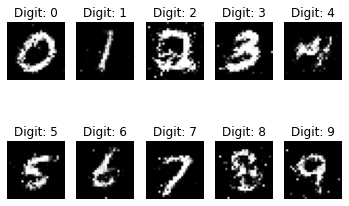

8001 [D loss: 0.674643, acc.: 56.25%] [G loss: 0.805761]
8002 [D loss: 0.705746, acc.: 48.44%] [G loss: 0.776848]
8003 [D loss: 0.711105, acc.: 51.56%] [G loss: 0.787550]
8004 [D loss: 0.652780, acc.: 60.94%] [G loss: 0.796092]
8005 [D loss: 0.655485, acc.: 59.38%] [G loss: 0.834703]
8006 [D loss: 0.695168, acc.: 53.12%] [G loss: 0.798795]
8007 [D loss: 0.674654, acc.: 54.69%] [G loss: 0.746925]
8008 [D loss: 0.664441, acc.: 64.06%] [G loss: 0.838605]
8009 [D loss: 0.699761, acc.: 59.38%] [G loss: 0.792270]
8010 [D loss: 0.654191, acc.: 60.94%] [G loss: 0.781996]
8011 [D loss: 0.654487, acc.: 56.25%] [G loss: 0.775173]
8012 [D loss: 0.728430, acc.: 54.69%] [G loss: 0.766119]
8013 [D loss: 0.631369, acc.: 65.62%] [G loss: 0.761814]
8014 [D loss: 0.672153, acc.: 53.12%] [G loss: 0.741871]
8015 [D loss: 0.688669, acc.: 48.44%] [G loss: 0.779522]
8016 [D loss: 0.647336, acc.: 65.62%] [G loss: 0.822598]
8017 [D loss: 0.702137, acc.: 56.25%] [G loss: 0.800470]
8018 [D loss: 0.683629, acc.: 5

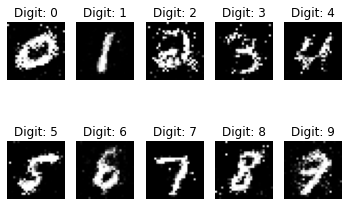

8201 [D loss: 0.662993, acc.: 68.75%] [G loss: 0.805203]
8202 [D loss: 0.660777, acc.: 56.25%] [G loss: 0.776484]
8203 [D loss: 0.683673, acc.: 54.69%] [G loss: 0.746387]
8204 [D loss: 0.683787, acc.: 42.19%] [G loss: 0.760117]
8205 [D loss: 0.656005, acc.: 65.62%] [G loss: 0.779316]
8206 [D loss: 0.737382, acc.: 42.19%] [G loss: 0.775766]
8207 [D loss: 0.679862, acc.: 56.25%] [G loss: 0.746326]
8208 [D loss: 0.690708, acc.: 51.56%] [G loss: 0.812927]
8209 [D loss: 0.688922, acc.: 45.31%] [G loss: 0.766870]
8210 [D loss: 0.683804, acc.: 62.50%] [G loss: 0.823031]
8211 [D loss: 0.670371, acc.: 56.25%] [G loss: 0.828821]
8212 [D loss: 0.671629, acc.: 57.81%] [G loss: 0.816472]
8213 [D loss: 0.659589, acc.: 62.50%] [G loss: 0.785056]
8214 [D loss: 0.648025, acc.: 59.38%] [G loss: 0.794584]
8215 [D loss: 0.685945, acc.: 54.69%] [G loss: 0.840375]
8216 [D loss: 0.645532, acc.: 57.81%] [G loss: 0.747941]
8217 [D loss: 0.638999, acc.: 59.38%] [G loss: 0.781891]
8218 [D loss: 0.649092, acc.: 5

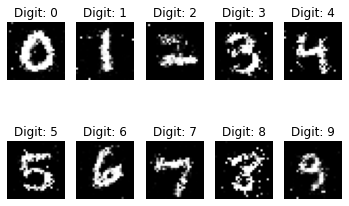

8401 [D loss: 0.763938, acc.: 45.31%] [G loss: 0.747302]
8402 [D loss: 0.629430, acc.: 56.25%] [G loss: 0.752541]
8403 [D loss: 0.665503, acc.: 53.12%] [G loss: 0.737927]
8404 [D loss: 0.675417, acc.: 54.69%] [G loss: 0.778564]
8405 [D loss: 0.691861, acc.: 45.31%] [G loss: 0.727542]
8406 [D loss: 0.659280, acc.: 57.81%] [G loss: 0.781851]
8407 [D loss: 0.684138, acc.: 50.00%] [G loss: 0.743477]
8408 [D loss: 0.695276, acc.: 46.88%] [G loss: 0.788492]
8409 [D loss: 0.680848, acc.: 59.38%] [G loss: 0.782566]
8410 [D loss: 0.651430, acc.: 65.62%] [G loss: 0.770350]
8411 [D loss: 0.632105, acc.: 54.69%] [G loss: 0.754236]
8412 [D loss: 0.665266, acc.: 48.44%] [G loss: 0.767063]
8413 [D loss: 0.697012, acc.: 56.25%] [G loss: 0.738988]
8414 [D loss: 0.695316, acc.: 45.31%] [G loss: 0.792840]
8415 [D loss: 0.673413, acc.: 60.94%] [G loss: 0.759169]
8416 [D loss: 0.645928, acc.: 62.50%] [G loss: 0.723191]
8417 [D loss: 0.692479, acc.: 53.12%] [G loss: 0.789527]
8418 [D loss: 0.670641, acc.: 5

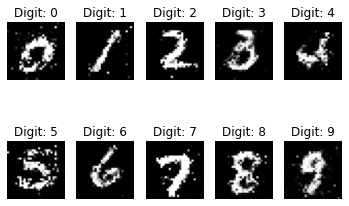

8601 [D loss: 0.664451, acc.: 59.38%] [G loss: 0.735710]
8602 [D loss: 0.659931, acc.: 54.69%] [G loss: 0.774183]
8603 [D loss: 0.704840, acc.: 43.75%] [G loss: 0.789633]
8604 [D loss: 0.714933, acc.: 39.06%] [G loss: 0.767040]
8605 [D loss: 0.662367, acc.: 57.81%] [G loss: 0.747532]
8606 [D loss: 0.676614, acc.: 54.69%] [G loss: 0.768358]
8607 [D loss: 0.680072, acc.: 48.44%] [G loss: 0.743154]
8608 [D loss: 0.667653, acc.: 56.25%] [G loss: 0.727901]
8609 [D loss: 0.686603, acc.: 53.12%] [G loss: 0.778473]
8610 [D loss: 0.693253, acc.: 51.56%] [G loss: 0.778451]
8611 [D loss: 0.685605, acc.: 57.81%] [G loss: 0.767264]
8612 [D loss: 0.655604, acc.: 53.12%] [G loss: 0.730542]
8613 [D loss: 0.672438, acc.: 54.69%] [G loss: 0.793591]
8614 [D loss: 0.661808, acc.: 54.69%] [G loss: 0.811191]
8615 [D loss: 0.649872, acc.: 54.69%] [G loss: 0.806284]
8616 [D loss: 0.675317, acc.: 62.50%] [G loss: 0.833830]
8617 [D loss: 0.659240, acc.: 65.62%] [G loss: 0.757497]
8618 [D loss: 0.694573, acc.: 4

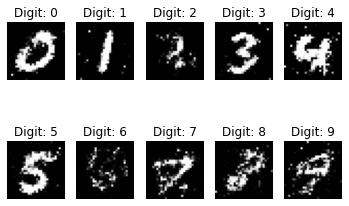

8801 [D loss: 0.617229, acc.: 67.19%] [G loss: 0.805610]
8802 [D loss: 0.652255, acc.: 53.12%] [G loss: 0.761850]
8803 [D loss: 0.703082, acc.: 51.56%] [G loss: 0.785112]
8804 [D loss: 0.652271, acc.: 57.81%] [G loss: 0.736349]
8805 [D loss: 0.685988, acc.: 51.56%] [G loss: 0.817441]
8806 [D loss: 0.668921, acc.: 56.25%] [G loss: 0.819560]
8807 [D loss: 0.663082, acc.: 62.50%] [G loss: 0.846354]
8808 [D loss: 0.651233, acc.: 56.25%] [G loss: 0.754470]
8809 [D loss: 0.667652, acc.: 56.25%] [G loss: 0.799382]
8810 [D loss: 0.659715, acc.: 54.69%] [G loss: 0.801146]
8811 [D loss: 0.670083, acc.: 57.81%] [G loss: 0.742155]
8812 [D loss: 0.667301, acc.: 59.38%] [G loss: 0.805055]
8813 [D loss: 0.664541, acc.: 56.25%] [G loss: 0.772416]
8814 [D loss: 0.685198, acc.: 59.38%] [G loss: 0.831156]
8815 [D loss: 0.679564, acc.: 59.38%] [G loss: 0.742075]
8816 [D loss: 0.688863, acc.: 48.44%] [G loss: 0.741877]
8817 [D loss: 0.663386, acc.: 53.12%] [G loss: 0.757798]
8818 [D loss: 0.706364, acc.: 4

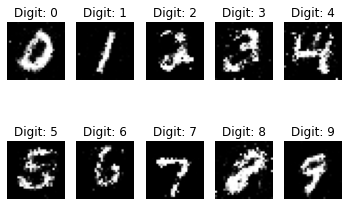

9001 [D loss: 0.644181, acc.: 67.19%] [G loss: 0.815680]
9002 [D loss: 0.676615, acc.: 54.69%] [G loss: 0.752039]
9003 [D loss: 0.673248, acc.: 51.56%] [G loss: 0.771583]
9004 [D loss: 0.680328, acc.: 56.25%] [G loss: 0.768897]
9005 [D loss: 0.644074, acc.: 68.75%] [G loss: 0.758906]
9006 [D loss: 0.665320, acc.: 64.06%] [G loss: 0.750431]
9007 [D loss: 0.691226, acc.: 53.12%] [G loss: 0.797508]
9008 [D loss: 0.700068, acc.: 59.38%] [G loss: 0.767249]
9009 [D loss: 0.666501, acc.: 56.25%] [G loss: 0.771268]
9010 [D loss: 0.677536, acc.: 62.50%] [G loss: 0.813058]
9011 [D loss: 0.689292, acc.: 53.12%] [G loss: 0.756656]
9012 [D loss: 0.665875, acc.: 56.25%] [G loss: 0.772517]
9013 [D loss: 0.659622, acc.: 56.25%] [G loss: 0.761634]
9014 [D loss: 0.654865, acc.: 54.69%] [G loss: 0.830475]
9015 [D loss: 0.668023, acc.: 54.69%] [G loss: 0.770353]
9016 [D loss: 0.715753, acc.: 53.12%] [G loss: 0.734901]
9017 [D loss: 0.681105, acc.: 57.81%] [G loss: 0.821319]
9018 [D loss: 0.655159, acc.: 5

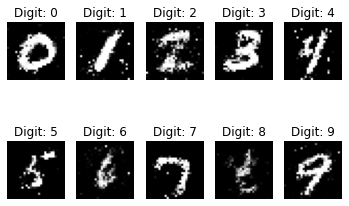

9201 [D loss: 0.668387, acc.: 53.12%] [G loss: 0.791369]
9202 [D loss: 0.741300, acc.: 53.12%] [G loss: 0.790487]
9203 [D loss: 0.668855, acc.: 50.00%] [G loss: 0.736114]
9204 [D loss: 0.603323, acc.: 65.62%] [G loss: 0.788470]
9205 [D loss: 0.693318, acc.: 57.81%] [G loss: 0.764010]
9206 [D loss: 0.637827, acc.: 70.31%] [G loss: 0.787700]
9207 [D loss: 0.695366, acc.: 57.81%] [G loss: 0.770246]
9208 [D loss: 0.667622, acc.: 51.56%] [G loss: 0.753387]
9209 [D loss: 0.725386, acc.: 42.19%] [G loss: 0.796929]
9210 [D loss: 0.681454, acc.: 53.12%] [G loss: 0.846073]
9211 [D loss: 0.682038, acc.: 56.25%] [G loss: 0.789812]
9212 [D loss: 0.654942, acc.: 59.38%] [G loss: 0.845000]
9213 [D loss: 0.664756, acc.: 56.25%] [G loss: 0.794574]
9214 [D loss: 0.647692, acc.: 54.69%] [G loss: 0.788747]
9215 [D loss: 0.656704, acc.: 53.12%] [G loss: 0.791887]
9216 [D loss: 0.708012, acc.: 53.12%] [G loss: 0.752280]
9217 [D loss: 0.696815, acc.: 53.12%] [G loss: 0.789459]
9218 [D loss: 0.670813, acc.: 6

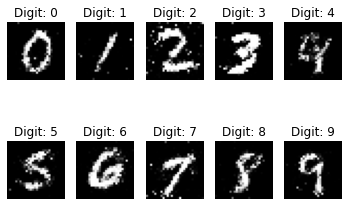

9401 [D loss: 0.677969, acc.: 57.81%] [G loss: 0.715257]
9402 [D loss: 0.652695, acc.: 54.69%] [G loss: 0.726757]
9403 [D loss: 0.703847, acc.: 45.31%] [G loss: 0.790273]
9404 [D loss: 0.693765, acc.: 48.44%] [G loss: 0.833798]
9405 [D loss: 0.682987, acc.: 50.00%] [G loss: 0.780344]
9406 [D loss: 0.679875, acc.: 57.81%] [G loss: 0.840921]
9407 [D loss: 0.708686, acc.: 53.12%] [G loss: 0.820351]
9408 [D loss: 0.692581, acc.: 57.81%] [G loss: 0.828228]
9409 [D loss: 0.682599, acc.: 57.81%] [G loss: 0.791900]
9410 [D loss: 0.681639, acc.: 54.69%] [G loss: 0.804720]
9411 [D loss: 0.682557, acc.: 57.81%] [G loss: 0.809235]
9412 [D loss: 0.679900, acc.: 54.69%] [G loss: 0.823604]
9413 [D loss: 0.674940, acc.: 48.44%] [G loss: 0.758395]
9414 [D loss: 0.671353, acc.: 53.12%] [G loss: 0.789238]
9415 [D loss: 0.652835, acc.: 68.75%] [G loss: 0.784261]
9416 [D loss: 0.684525, acc.: 53.12%] [G loss: 0.777303]
9417 [D loss: 0.671291, acc.: 56.25%] [G loss: 0.783091]
9418 [D loss: 0.639901, acc.: 5

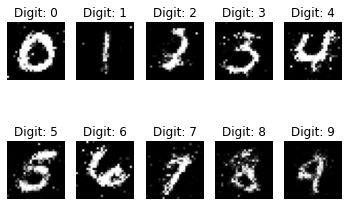

9601 [D loss: 0.638627, acc.: 56.25%] [G loss: 0.806132]
9602 [D loss: 0.616856, acc.: 62.50%] [G loss: 0.853325]
9603 [D loss: 0.698779, acc.: 59.38%] [G loss: 0.770197]
9604 [D loss: 0.687721, acc.: 53.12%] [G loss: 0.757857]
9605 [D loss: 0.670551, acc.: 64.06%] [G loss: 0.770276]
9606 [D loss: 0.636713, acc.: 57.81%] [G loss: 0.795290]
9607 [D loss: 0.658782, acc.: 62.50%] [G loss: 0.844161]
9608 [D loss: 0.590314, acc.: 71.88%] [G loss: 0.850867]
9609 [D loss: 0.688894, acc.: 54.69%] [G loss: 0.858278]
9610 [D loss: 0.660940, acc.: 51.56%] [G loss: 0.842787]
9611 [D loss: 0.659609, acc.: 62.50%] [G loss: 0.837952]
9612 [D loss: 0.659178, acc.: 64.06%] [G loss: 0.789347]
9613 [D loss: 0.660849, acc.: 54.69%] [G loss: 0.867475]
9614 [D loss: 0.643942, acc.: 67.19%] [G loss: 0.878381]
9615 [D loss: 0.643945, acc.: 64.06%] [G loss: 0.745277]
9616 [D loss: 0.697911, acc.: 54.69%] [G loss: 0.728979]
9617 [D loss: 0.679714, acc.: 54.69%] [G loss: 0.785856]
9618 [D loss: 0.698130, acc.: 5

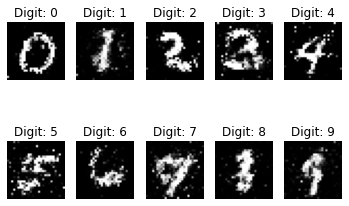

9801 [D loss: 0.672517, acc.: 62.50%] [G loss: 0.781956]
9802 [D loss: 0.663311, acc.: 64.06%] [G loss: 0.773899]
9803 [D loss: 0.676184, acc.: 67.19%] [G loss: 0.821044]
9804 [D loss: 0.621744, acc.: 62.50%] [G loss: 0.845478]
9805 [D loss: 0.654518, acc.: 67.19%] [G loss: 0.776518]
9806 [D loss: 0.667644, acc.: 54.69%] [G loss: 0.836416]
9807 [D loss: 0.659046, acc.: 56.25%] [G loss: 0.823636]
9808 [D loss: 0.687267, acc.: 57.81%] [G loss: 0.811842]
9809 [D loss: 0.671391, acc.: 62.50%] [G loss: 0.832721]
9810 [D loss: 0.664862, acc.: 57.81%] [G loss: 0.765599]
9811 [D loss: 0.646364, acc.: 68.75%] [G loss: 0.844946]
9812 [D loss: 0.649298, acc.: 65.62%] [G loss: 0.767256]
9813 [D loss: 0.638316, acc.: 65.62%] [G loss: 0.850748]
9814 [D loss: 0.674878, acc.: 53.12%] [G loss: 0.790195]
9815 [D loss: 0.599654, acc.: 70.31%] [G loss: 0.824526]
9816 [D loss: 0.649390, acc.: 59.38%] [G loss: 0.829633]
9817 [D loss: 0.671108, acc.: 53.12%] [G loss: 0.796800]
9818 [D loss: 0.604975, acc.: 7

In [4]:
cgan = CGAN()
cgan.train(epochs=10000, batch_size=32, sample_interval=200)

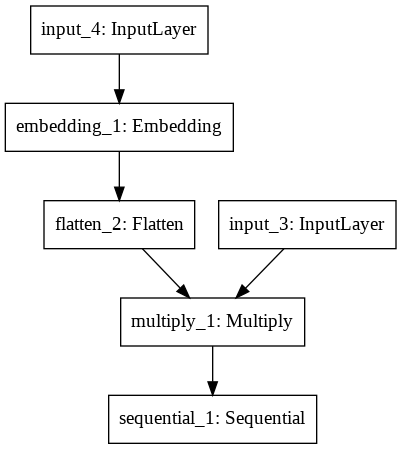

In [5]:
from tensorflow.keras.utils import plot_model
tensorflow.keras.utils.plot_model(cgan.generator)

In [6]:
# D combined

In [7]:
cgan.discriminator